In [297]:
import pandas as pd 
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt

In [298]:
df = pd.read_csv('./dataset-stroke.csv').drop(columns=['Unnamed: 0', 'id'])

In [299]:
# get dummies of the categoricals for the sake of visualization 
df['smoker'] = LabelEncoder().fit_transform(df.smoking_status.to_numpy().reshape(-1, 1))
df['residence'] = LabelEncoder().fit_transform(df.Residence_type.to_numpy().reshape(-1, 1))
df['work'] = LabelEncoder().fit_transform(df.work_type.to_numpy().reshape(-1, 1))

df.drop(columns=['smoking_status', 'Residence_type', 'work_type'], inplace=True)

/Users/dminzi-lt/miniforge3/envs/overkill/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [300]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,smoker,residence,work
0,Female,24.0,0,0,Yes,85.55,63.3,0,2,1,2
1,Male,57.0,1,0,Yes,78.92,27.7,1,1,1,0
2,Female,69.0,0,0,Yes,103.73,34.7,0,2,0,2
3,Male,60.0,0,0,Yes,227.23,40.0,0,1,1,3
4,Female,65.0,0,0,Yes,82.72,29.8,0,3,1,0


In [301]:
# again just temporary for this visualization 
df['gender'] = OneHotEncoder().fit_transform(df.gender.to_numpy().reshape(-1, 1)).toarray()
df['ever_married'] = OneHotEncoder().fit_transform(df.ever_married.to_numpy().reshape(-1, 1)).toarray()

In [302]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,smoker,residence,work
0,1.0,24.0,0,0,0.0,85.55,63.3,0,2,1,2
1,0.0,57.0,1,0,0.0,78.92,27.7,1,1,1,0
2,1.0,69.0,0,0,0.0,103.73,34.7,0,2,0,2
3,0.0,60.0,0,0,0.0,227.23,40.0,0,1,1,3
4,1.0,65.0,0,0,0.0,82.72,29.8,0,3,1,0


In [303]:
labels = df.stroke.to_numpy()
df.drop(columns=['stroke','bmi'], inplace=True)

In [304]:
df.dropna(inplace=True)

In [305]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=1)

num_pipe = Pipeline([
    ('imputer', imputer),
    ('std_scaler', StandardScaler())
])

X = num_pipe.fit_transform(df)

In [306]:
import hdbscan

clst = hdbscan.HDBSCAN()

clst.fit(X)

HDBSCAN()

In [307]:
df['hdb'] = clst.labels_

In [308]:
df['stroke'] = labels

In [309]:
df[df.stroke==1]

,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,smoker,residence,work,hdb,stroke
1,0.0,57.00,1,0,0.0,78.92,1,1,0,11,1
16,1.0,74.00,0,0,0.0,74.96,2,1,3,42,1
31,1.0,81.00,0,0,0.0,184.40,2,0,2,-1,1
42,0.0,71.00,1,1,1.0,216.94,2,0,0,-1,1
44,0.0,78.00,0,0,0.0,133.19,1,1,3,-1,1
...,...,...,...,...,...,...,...,...,...,...,...
2220,1.0,79.00,0,1,0.0,226.98,2,1,2,1,1
2263,1.0,71.00,0,0,0.0,263.32,2,1,0,-1,1
2291,1.0,1.32,0,0,1.0,70.37,0,1,4,59,1
2292,1.0,48.00,0,0,0.0,74.11,2,1,2,55,1


In [310]:
import umap

red = umap.UMAP()
embed = red.fit_transform(X)

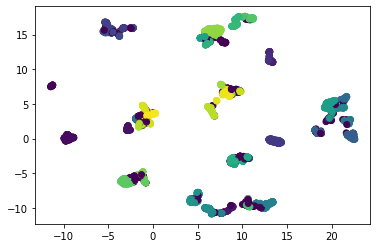

In [311]:
plt.scatter(
    embed[:, 0],
    embed[:, 1],
    c=df.hdb
)

In [312]:
df.drop(columns=['stroke'],inplace=True)

In [313]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, labels, train_size=0.8, stratify=labels)


In [314]:
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier(2)

In [315]:
knc.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2)

In [316]:
knc.score(X_test, y_test)

0.948051948051948

In [317]:
# Helper function that allows you to draw nicely formatted confusion matrices
def draw_confusion_matrix(y, yhat, classes):
    '''
        Draws a confusion matrix for the given target and predictions
        Adapted from scikit-learn and discussion example.
    '''
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=90)
    plt.yticks(np.arange(num_classes), classes)
    
    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [318]:
import itertools
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score

def model_report_from(model):
    y_test_pred = model.predict(X_test)

    print(f"accuracy = {model.score(X_test, y_test)}")
    print(f"precision = {precision_score(y_test, y_test_pred)}")
    print(f"recall = {recall_score(y_test, y_test_pred)}")
    print(f"f1 = {f1_score(y_test, y_test_pred)}")

    # display confusion matrix
    draw_confusion_matrix(y_test, y_test_pred, ["NO STROKE", "STROKE"])

    # draw ROC curve
    plot_roc_curve(model, X_test, y_test)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("ROC Curve")
    plt.ylabel("True Positive Rate (Recall)")
    plt.xlabel("False Positive Rate")
    plt.legend(loc="lower right")
    plt.show()

    print(f"ROC AUC score = {roc_auc_score(y_test, y_test_pred)}")

accuracy = 0.948051948051948
precision = 0.5
recall = 0.041666666666666664
f1 = 0.07692307692307693


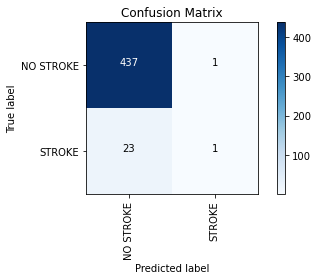

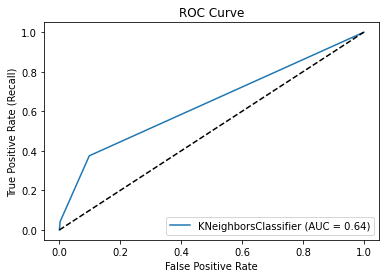

ROC AUC score = 0.5196917808219178


In [319]:
model_report_from(knc)